In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

[ 1.00288617 -0.37852408]


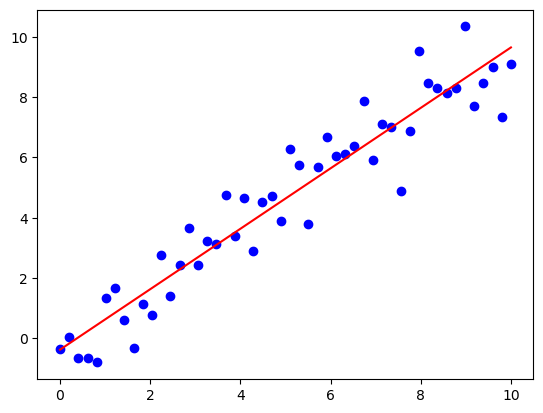

In [14]:
x = np.linspace(0, 10)
y = x + np.random.standard_normal(len(x))

reg = np.polyfit(x, y, deg=1)
print(reg)

plt.figure()
plt.plot(x, y, 'bo')
plt.plot(x, np.polyval(reg, x), 'r')

In [15]:
raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',
                           index_col=0, parse_dates=True).dropna()
raw.head(10)

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-04,30.572827,30.950,20.880,133.900,173.08,113.33,1132.99,20.04,1.4411,1120.00,47.71,109.80
2010-01-05,30.625684,30.960,20.870,134.690,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.70
2010-01-06,30.138541,30.770,20.800,132.250,174.26,113.71,1137.14,19.16,1.4412,1138.50,49.34,111.51
2010-01-07,30.082827,30.452,20.600,130.000,177.67,114.19,1141.69,19.06,1.4318,1131.90,49.10,110.82
2010-01-08,30.282827,30.660,20.830,133.520,174.31,114.57,1144.98,18.13,1.4412,1136.10,49.84,111.37
2010-01-11,30.015684,30.270,20.950,130.308,171.56,114.73,1146.98,17.55,1.4513,1152.60,50.17,112.85
2010-01-12,29.674256,30.070,20.608,127.350,167.82,113.66,1136.22,18.25,1.4494,1127.30,48.35,110.49
2010-01-13,30.092827,30.350,20.960,129.110,169.07,114.62,1145.68,17.85,1.4510,1138.40,48.86,111.54
2010-01-14,29.918542,30.960,21.480,127.350,168.53,114.93,1148.46,17.63,1.4502,1142.85,48.60,112.03


In [17]:
data = pd.DataFrame(raw['EUR='])
data.rename(columns={'EUR=': 'price'}, inplace=True)

In [20]:
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    data[col] = data['price'].shift(lag)
    cols.append(col)
    data.dropna(inplace=True)

In [23]:
reg = np.linalg.lstsq(data[cols], data['price'],
                               rcond=None)[0]
data['prediction'] = np.dot(data[cols], reg)

<Axes: xlabel='Date'>

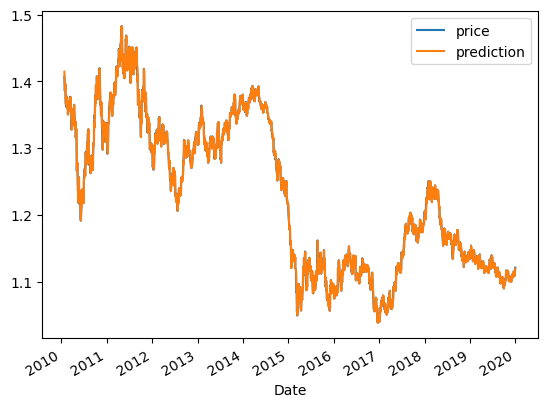

In [26]:
data[['price', 'prediction']].plot()

<Axes: xlabel='Date'>

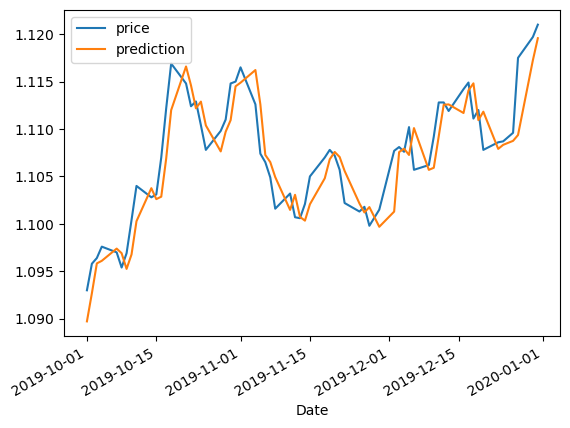

In [27]:
data[['price', 'prediction']].loc['2019-10-1':].plot()

In [31]:
data['return'] = np.log(data['price'] / data['price'].shift(1))
data.dropna(inplace=True)

cols = []
lags = 5
for lag in range(1, lags+1):
    col = f'flag_{lag}'
    data[col] = data['return'].shift(lag)
    cols.append(col)
data.dropna(inplace=True)

req = np.linalg.lstsq(data[cols], data['return'], rcond=None)[0]

In [32]:
data['prediction'] = np.dot(data[cols], req)

<Axes: xlabel='Date'>

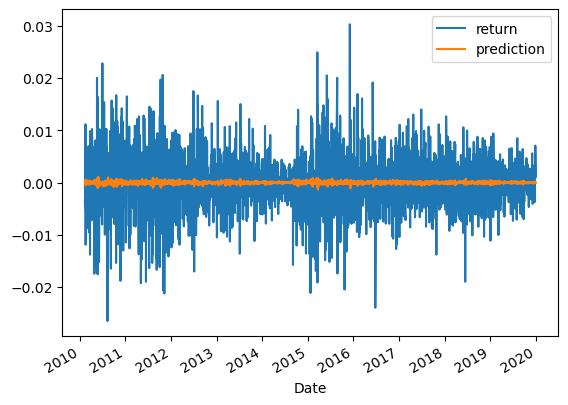

In [33]:
data[['return', 'prediction']].plot()

In [37]:
data['movement_direction'] = np.sign(np.dot(data[cols], reg))
data['movement_direction'].value_counts()

movement_direction
 1.0    1251
-1.0    1238
Name: count, dtype: int64

In [41]:
hits = np.sign(data['return'] * data['movement_direction'])
hits = hits.value_counts()

In [47]:
hits[1] / sum(hits)

0.4909602249899558

#### Linear Regression with scikit-learn

In [56]:
data['momentum'] = data['price'].shift(1).rolling(5).mean()
data['volatility'] = data['price'].shift(1).rolling(20).std()
data['distance'] = (data['price'] - data['price'].rolling(50).mean()).shift(1)
data.dropna(inplace=True)

In [57]:
cols.extend(['momentum', 'volatility', 'distance'])